In [65]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import MobileNetV2



from io import BytesIO


Num GPUs Available:  1


In [59]:
import os
import random
import shutil

# Set the path to the main folder containing real and fake subfolders
main_folder = '/home/real/datasets'

# Set the paths to the train and test folders
train_folder = 'dataset/train'
test_folder = 'dataset/test'

# Set the train/test split ratio
train_ratio = 0.8

# Create train and test folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

balance = True



# Function to copy files from source to destination folder
def copy_files(file_list, src_folder, dest_folder):
    for file_name in file_list:

        #check if the image file is valid
        try:
            img = Image.open(os.path.join(src_folder, file_name)) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', file_name) # print out the names of corrupt files
            continue



        src_path = os.path.join(src_folder, file_name)
        dest_path = os.path.join(dest_folder, file_name)
        shutil.copy(src_path, dest_path)

# Iterate through the subfolders in the main folder
for subfolder in ['real', 'fake']:
    subfolder_path = os.path.join(main_folder, subfolder)
    files = os.listdir(subfolder_path)
    random.shuffle(files)

    # Split the files into train and test sets
    train_files = files[:int(train_ratio * len(files))]
    test_files = files[int(train_ratio * len(files)):]

    # Copy train files to the train folder
    train_subfolder_path = os.path.join(train_folder, subfolder)
    os.makedirs(train_subfolder_path, exist_ok=True)
    copy_files(train_files, subfolder_path, train_subfolder_path)

    # Copy test files to the test folder
    test_subfolder_path = os.path.join(test_folder, subfolder)
    os.makedirs(test_subfolder_path, exist_ok=True)
    copy_files(test_files, subfolder_path, test_subfolder_path)

Bad file: ._a8caab69865348b69428e9334cfb1776.jpg
Bad file: ._525546db374443c089e7d6aa8bd03977.jpg
Bad file: ._00f0dd89600347a4b9f4ec501fe7aa12.jpg
Bad file: ._c28b9ade9c6e4698bb3a2caf3d9b420d.jpg
Bad file: ._b018cf2f9be2473ab6397c084a03af4c.jpg
Bad file: ._b7d831f7e20f480ea50a80754962b2ba.jpg
Bad file: ._14f6ffd41be14ef4a6d73937fbca5fae.jpg
Bad file: ._6bbffabe70ee46189c9c7f55adffd2f3.jpg
Bad file: ._b908f7d92c974781a8b0d0454957326a.jpg
Bad file: ._e5933f6711ef4386b8c737aef29194ed.jpg
Bad file: ._a1c24392cf68458a8978d8161bbb4eda.jpg
Bad file: ._de75321aedf445228cb4082c66cc0426.jpg
Bad file: ._80af107644ac4f198aedf6b9b4f05e73.jpg
Bad file: ._e534d4995dfb4dd8ba994e66dd3a55bf.jpg
Bad file: ._bd69c592d2564e668d7c192c7a47ecf4.jpg
Bad file: ._c3e4166e66ea43fda057ef8361c3b129.jpg
Bad file: ._fda30ef3a29d4bb9a5a2fae71e4b0915.jpg
Bad file: ._85ffaf0b52a24400a20c6fd750b14554.jpg
Bad file: ._1a2287fc25f14cdcbc7f6a8d8107ba09.jpg
Bad file: ._5d6e2200be2a4db4afa9e9c0e0c69d27.jpg
Bad file: ._cbe880dc

In [67]:

# # Define the model architecture
# model = tf.keras.Sequential([
#     layers.Conv2D(64, (3, 3), activation='relu', input_shape=(640, 480, 3), kernel_regularizer=regularizers.l2(0.01)),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#
#     layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#
#     layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#
#     layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#
#     layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#
#     layers.Flatten(),
#     layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.5),
#
#     layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.5),
#
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.5),
#
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.5),
#
#     layers.Dense(1, activation='sigmoid')
# ])
#
# # Compiling the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#
#
#
#
#
# # Print the model summary
# model.summary()



# Load MobileNetV2 without the top classification layers
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [68]:

# Specify the paths to the dataset folders
train_data_dir = 'dataset/train'
test_data_dir = 'dataset/test'

# Set the image size and batch size
# image_size = (640, 480)
image_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator for data augmentation and preprocessing
data_generator = ImageDataGenerator(rescale=1./255)

# Load and prepare the training data
train_data = data_generator.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Load and prepare the testing data
test_data = data_generator.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 47283 images belonging to 2 classes.
Found 11797 images belonging to 2 classes.


In [69]:
 # Define the number of training and testing steps per epoch
train_steps_per_epoch = train_data.samples // batch_size
test_steps_per_epoch = test_data.samples // batch_size
# Define the paths for saving the checkpoints and the best model
checkpoint_path = "checkpoint/model_checkpoint"
best_model_path = "best_model/best_model_savedmodel"

# Ensure the checkpoint directory exists
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

# Create the ModelCheckpoint callback to save the model at the end of each epoch
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  # Save based on validation loss
    save_best_only=True,  # Save only the best model
    save_weights_only=False,  # Save the entire model
    mode='min',  # Minimize validation loss
    verbose=1
)
# early_stopping_callback = EarlyStopping(
#     monitor='val_loss',
#     patience=5,  # Number of epochs with no improvement before stopping
#     mode='min',  # Minimize validation loss
#     verbose=1
# )

# Train the model
history=model.fit(
    train_data,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=test_data,
    validation_steps=test_steps_per_epoch,
    callbacks=[checkpoint_callback]
)

best_model = tf.keras.models.load_model(checkpoint_path)  # Load the best model from the checkpoint
best_model.save(best_model_path)
model.save('last_model.savedmodel')

Epoch 1/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9267
Epoch 1: val_loss improved from inf to 0.15703, saving model to checkpoint/model_checkpoint


INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


1477/1477 [==============================] - 131s 88ms/step - loss: 0.1913 - accuracy: 0.9267 - val_loss: 0.1570 - val_accuracy: 0.9417
Epoch 2/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1594 - accuracy: 0.9390
Epoch 2: val_loss improved from 0.15703 to 0.14393, saving model to checkpoint/model_checkpoint


INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


1477/1477 [==============================] - 130s 88ms/step - loss: 0.1594 - accuracy: 0.9390 - val_loss: 0.1439 - val_accuracy: 0.9456
Epoch 3/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9441
Epoch 3: val_loss improved from 0.14393 to 0.14108, saving model to checkpoint/model_checkpoint
INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


1477/1477 [==============================] - 130s 88ms/step - loss: 0.1502 - accuracy: 0.9441 - val_loss: 0.1411 - val_accuracy: 0.9482
Epoch 4/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9481
Epoch 4: val_loss improved from 0.14108 to 0.13731, saving model to checkpoint/model_checkpoint
INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


1477/1477 [==============================] - 126s 86ms/step - loss: 0.1410 - accuracy: 0.9481 - val_loss: 0.1373 - val_accuracy: 0.9484
Epoch 5/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9486
Epoch 5: val_loss did not improve from 0.13731
1477/1477 [==============================] - 118s 80ms/step - loss: 0.1379 - accuracy: 0.9486 - val_loss: 0.1484 - val_accuracy: 0.9461
Epoch 6/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.9513
Epoch 6: val_loss did not improve from 0.13731
1477/1477 [==============================] - 122s 83ms/step - loss: 0.1310 - accuracy: 0.9513 - val_loss: 0.1434 - val_accuracy: 0.9471
Epoch 7/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9532
Epoch 7: val_loss did not improve from 0.13731
1477/1477 [==============================] - 119s 81ms/step - loss: 0.1255 - accuracy: 0.9532 - val_loss: 0.1438 - val_accuracy: 0.9483
Epoch 8/20
1477/1477 

INFO:tensorflow:Assets written to: checkpoint/model_checkpoint/assets


1477/1477 [==============================] - 124s 84ms/step - loss: 0.1154 - accuracy: 0.9575 - val_loss: 0.1359 - val_accuracy: 0.9515
Epoch 11/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9597
Epoch 11: val_loss did not improve from 0.13590
1477/1477 [==============================] - 121s 82ms/step - loss: 0.1103 - accuracy: 0.9597 - val_loss: 0.1378 - val_accuracy: 0.9511
Epoch 12/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9608
Epoch 12: val_loss did not improve from 0.13590
1477/1477 [==============================] - 126s 85ms/step - loss: 0.1075 - accuracy: 0.9608 - val_loss: 0.1410 - val_accuracy: 0.9511
Epoch 13/20
1477/1477 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9619
Epoch 13: val_loss did not improve from 0.13590
1477/1477 [==============================] - 124s 84ms/step - loss: 0.1031 - accuracy: 0.9619 - val_loss: 0.1395 - val_accuracy: 0.9522
Epoch 14/20
147

INFO:tensorflow:Assets written to: best_model/best_model_savedmodel/assets


INFO:tensorflow:Assets written to: last_model.savedmodel/assets


INFO:tensorflow:Assets written to: last_model.savedmodel/assets


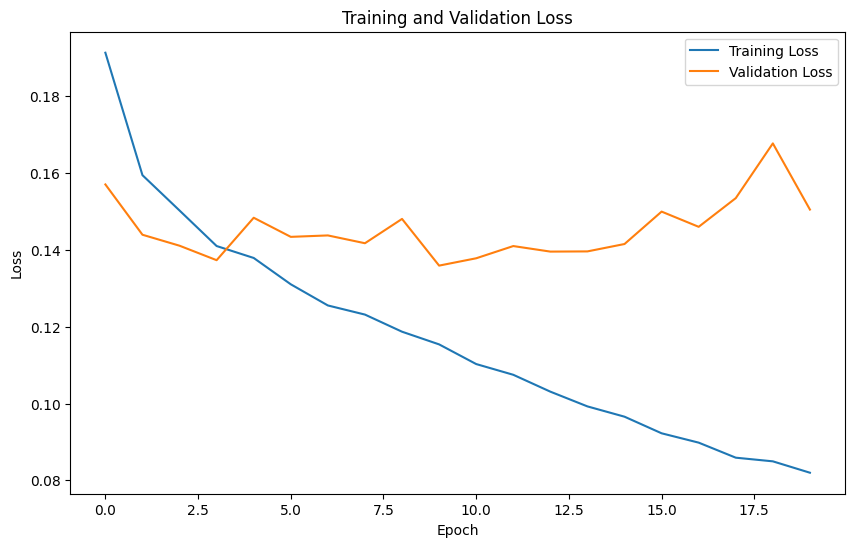

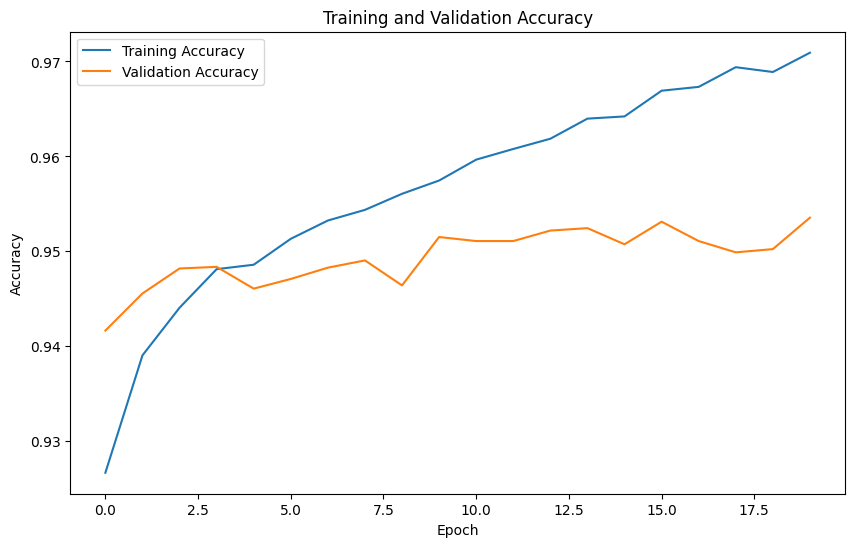

In [70]:
# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

2/2 [==============================] - 0s 11ms/step
Real Accuracy: 0.9791666666666666
Fake Accuracy: 0.918918918918919


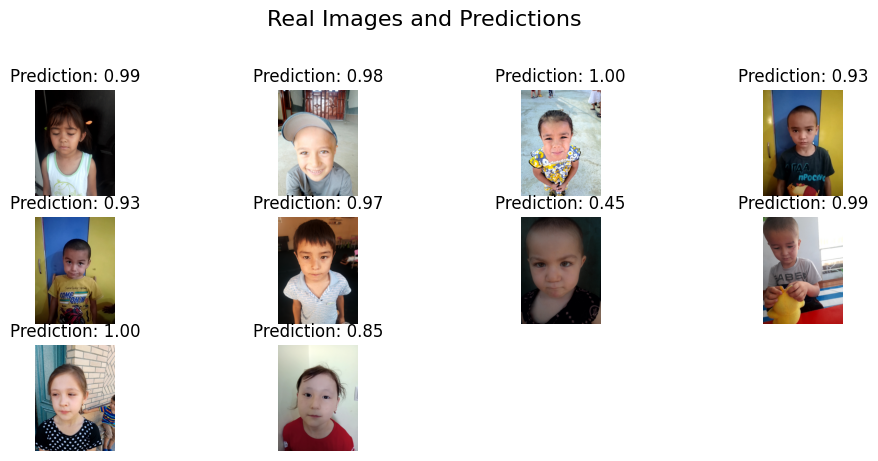

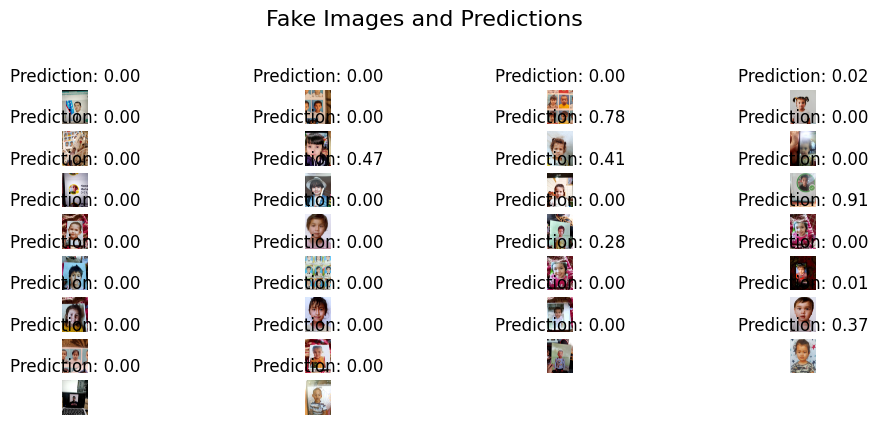

In [80]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the paths for the validation data
validation_folder = '/home/real/datasets/validation'
real_folder = os.path.join(validation_folder, 'real')
fake_folder = os.path.join(validation_folder, 'fake')


best_model_path = "checkpoint/model_checkpoint"
best_model = tf.keras.models.load_model(best_model_path)
# Load the model
# Function to preprocess the image
def preprocess_image(image_path, image_size):
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# Function to predict on the validation data
def predict_on_validation_data(validation_folder, image_size, model):
    real_images = []
    fake_images = []

    for image_file in os.listdir(real_folder):
        image_path = os.path.join(real_folder, image_file)
        real_images.append(preprocess_image(image_path, image_size))

    for image_file in os.listdir(fake_folder):
        image_path = os.path.join(fake_folder, image_file)
        fake_images.append(preprocess_image(image_path, image_size))

    real_images = np.vstack(real_images)
    fake_images = np.vstack(fake_images)

    real_predictions = model.predict(real_images)
    fake_predictions = model.predict(fake_images)

    return real_predictions, fake_predictions

# Set the image size for the model
# image_size = (640, 480)  # Replace with the appropriate image size based on your model's input requirements
image_size = (224, 224)
def plot_images_and_predictions(images, predictions, title):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        # plt.subplot( 2, len(images)//2, i+1)
        plt.subplot( len(images)//2, 4, i+1)
        # image in rgb format
        # plt.imshow(mpimg.imread(images[i]))
        plt.imshow(cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB))
        plt.title(f'Prediction: {predictions[i][0]:.2f}')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()
# Run validation on the data
real_predictions, fake_predictions = predict_on_validation_data(validation_folder, image_size, model)

# Assuming the model is a binary classifier, you can calculate the accuracy for both classes
real_accuracy = np.mean(real_predictions > 0.5)
fake_accuracy = np.mean(fake_predictions < 0.5)

print("Real Accuracy:", real_accuracy)
print("Fake Accuracy:", fake_accuracy)
# Get the file paths for the real and fake images
real_images_paths = [os.path.join(real_folder, image_file) for image_file in os.listdir(real_folder)]
fake_images_paths = [os.path.join(fake_folder, image_file) for image_file in os.listdir(fake_folder)]

# Show images and associated predictions in a grid
plot_images_and_predictions(real_images_paths[:10], real_predictions[:10], title="Real Images and Predictions")
plot_images_and_predictions(fake_images_paths[:30], fake_predictions[:30], title="Fake Images and Predictions")

In [90]:
# get first layer name
print(model.layers[0].name)

# get last layer name
print(model.layers[-1].name)


mobilenetv2_1.00_224
dense_36


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your image size
image_size = (224, 224)  # Adjust this to your desired image size

# Define the path to the main folder containing 'real' and 'fake' subfolders
data_dir = 'path/to/dataset'

# Define the batch size for the data generator
batch_size = 32

# Use ImageDataGenerator for data loading and augmentation
datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)  # Normalize pixel values and split for validation

# Load the data from the main folder, split into training and validation sets
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)
# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

In [6]:
#save model;
model.save('model.h5')

/home/real/miniconda3/envs/anti_spoofing_train/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
#load model;
model = tf.keras.models.load_model('model.h5')

2023-07-30 10:39:53.293558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 10:39:53.293707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-30 10:39:53.293755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 239, 319, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 118, 158, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 156, 64)      36928     
                                                                 
 flatten (Flatten)           (None, 1158144)           0

In [18]:
# run model on a single image
fake_image = 'dataset/test/real/0c73777d1a944251869584b56d0997ef.jpg'

fake_image = tf.keras.preprocessing.image.load_img(
    fake_image, target_size=image_size
)

fake_image = tf.keras.preprocessing.image.img_to_array(fake_image)
fake_image = np.expand_dims(fake_image, axis=0)
fake_image = fake_image / 255


prediction = model.predict(fake_image)
print("Prediction:", prediction)
print("predicted class:", "fake" if prediction < 0.5 else "real")

1/1 [==============================] - 0s 69ms/step
Prediction: [[1.]]
predicted class: real


In [ ]:
#save model tensortrt model for inference
import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from tensorflow.python.saved_model import tag_constants

# Convert the model
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='model.h5',
    conversion_params=trt.DEFAULT_TRT_CONVERSION_PARAMS)
converter.convert()
converter.save(output_saved_model_dir='model_trt')



In [74]:
#save model tensorflow saved model format
model.save('model.savedmodel')


INFO:tensorflow:Assets written to: model.savedmodel/assets


INFO:tensorflow:Assets written to: model.savedmodel/assets


In [77]:
# get first and last layer of the model name and s

AttributeError: 'Sequential' object has no attribute 'sammary'